## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings("ignore")

In [2]:
def imshow(a):
  display(PIL.Image.fromarray(a))

## Loading dataset

In [3]:
ds, ds_info = tfds.load(
    "celeb_a",
    split='train[:10%]',
    shuffle_files=True,
    with_info=True
)

In [4]:
## ds is tensorflow object and each sample is dict with some features not only image, convert to numpy for simplicity 
ds = np.vstack(tfds.as_numpy(ds))
ds = np.array(list(map(lambda x: x[0]['image'], ds)))
ds.shape

(16277, 218, 178, 3)

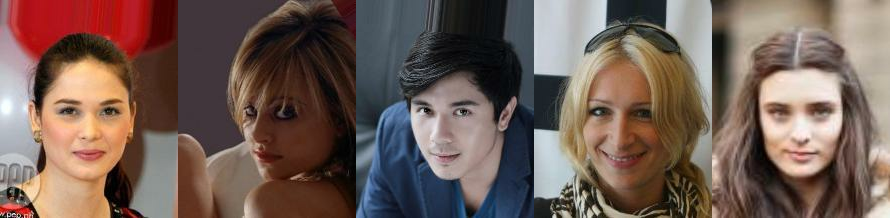

In [5]:
idxs = np.random.choice(len(ds), 5)
imshow(np.concatenate(ds[idxs], 1))

## Masking

In [118]:
def create_line_mask(img):
    mask = np.full(img.shape, 255, np.uint8)
    for _ in range(np.random.randint(4, 10)):
      x1, x2 = np.random.randint(1, img.shape[1]), np.random.randint(1, img.shape[1])
      y1, y2 = np.random.randint(1, img.shape[0]), np.random.randint(1, img.shape[0])
      thickness = np.random.randint(3, 8)
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

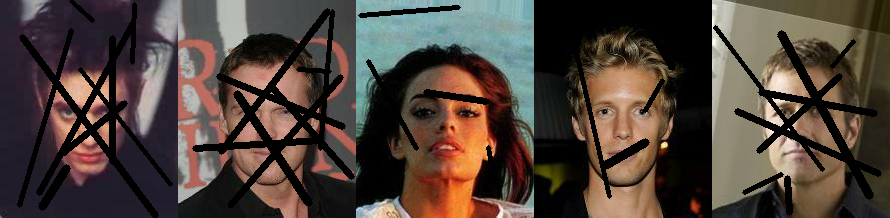

In [121]:
idxs = np.random.choice(len(ds), 5)
masked = np.array(list(map(create_line_mask, ds[idxs])))
imshow(np.concatenate(masked, 1))

In [119]:
def create_square_mask(img, size=80):
    mask = np.full(img.shape, 255, np.uint8)
    x1, y1 = np.random.randint(20, img.shape[1]-size-20), np.random.randint(20, img.shape[0]-size-20)
    cv2.rectangle(mask,(x1,y1),(x1+size,y1+size), (1,1,1), -1)

    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

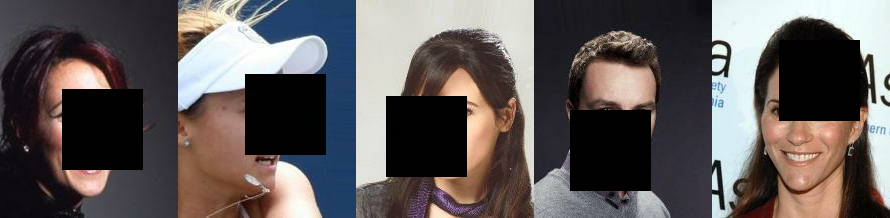

In [124]:
idxs = np.random.choice(len(ds), 5)
masked = np.array(list(map(create_square_mask, ds[idxs])))
imshow(np.concatenate(masked, 1))